In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [164]:
# Loading data
df = pd.read_csv('IG.csv').assign(Date = lambda x: pd.to_datetime(x['Date'])).set_index("Date")
df.head(2)

,BO,C,CC,CL,CT,GC,HO,KC,LB,LC,LCO,LSU,NG,OJ,RR,S,SB,SI,SM,W
Date,,,,,,,,,,,,,,,,,,,,
2001-01-04,1453.0,229.766667,766.000000,2817.666667,6012.0,267.483333,8567.333333,6341.666667,20076.666667,7700.833333,2532.333333,251.233333,8770.000000,7150.0,5995.0,494.266667,1028.666667,4.520000,19033.333333,283.433333
2001-01-05,1456.0,227.000000,799.333333,2819.666667,5949.0,267.816667,8657.666667,6381.666667,19693.333333,7674.166667,2545.000000,252.333333,9170.333333,7490.0,5960.0,490.266667,1029.333333,4.546667,18823.333333,282.500000


The dataframe contains daily prices of 20 different products.

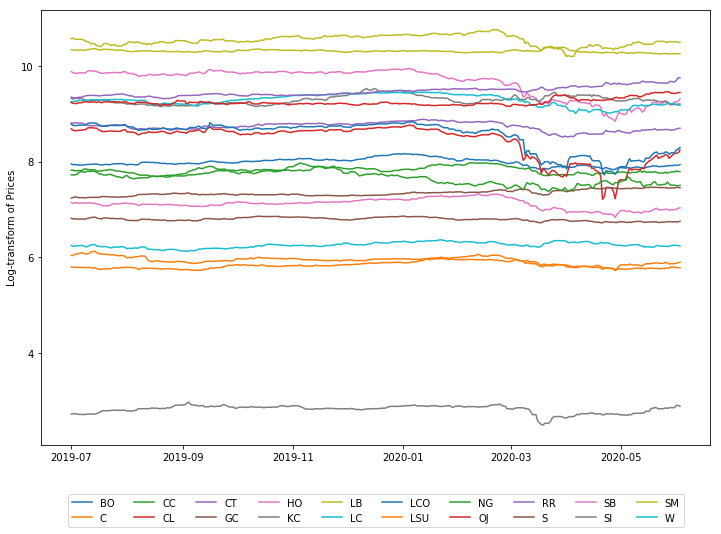

In [230]:
fig, axs = plt.subplots(figsize = (12,8))

df_plot = df.last('12M')
for col in df.columns:
    plt.plot(df_plot.index, np.log(df_plot[col]), label = col)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol = 10)
plt.xlabel('')
plt.ylabel('Log-transform of Prices');

Time series plots of all products' prices do not display any visual trends, we will assume absence of trends in further analysis.

# Theory on stationarity

Performing the Augmented Dickey-Fuller (ADF) test for $X$.

ADF test equation for $x$:

$\Delta{X_t} = \alpha+\beta{t}+\rho{X_{t-1}}+\gamma_1\Delta{X_{t-1}}+...+\gamma_L\Delta{X_{t-L}}+\varepsilon_t$.

When the process does not have any trend, $\beta$ is equal to 0.

The null hypothesis is that the process has unit root ($\rho$ is non-zero) and is non-stationary.

The ADF test statistic is larger than the critical value $->$ we cannot reject the null hypothesis, we conclude that process is non-stationary.

The ADF test satistic is smaller than the critical value $->$ we reject the null hypothesis and conclude that process is stationary  or does not have time-dependent structure.

Critical value for the varaible $\rho$ without determenistic trend is equal to -2.872, critical value for the variable with determenistic trend is equal to -3.5.

# Theory on cointegration

$x_t$ and $y_t$ are cointegrated if both series are non-stationary, but a linear combination (say $y_t − cx_t$) is stationary.

Performing the two-step Engle-Granger test for cointegration of the time series $X$ and $Y$.

Step 1. 

1. Perform OLS regression to find estimators $a$ and $b$ for the model: $X_t=\alpha+\beta{Y_t}+\varepsilon_t$.

2. Calculate residuals: $e_t=X_t-a-bY_t$.

Step 2.
Perform ADF test on $e_t$. Test equation: $\Delta{e}_t=\alpha+\rho{e}_{t-1}+\beta_1\Delta{e}_{t-1}+...+\beta_L\Delta{e}_{t-L}+\omega_t$. 

Critical value for $\rho$ without determenistic trend is -3.4, for that with determenistic trend is -3.8.
    

In [166]:
# Helper functions

def ADF_test(df, crit_val, period):
    '''
    Stationarity test for time series without determenistic trend
    
    '''
    df = df.last(period)
    nobs = df.shape[0]
    
    non_stationary = []
    stationary = []
    nobs = df.shape[0]
    
    for i, col in enumerate(df.columns):
        
        result = adfuller(df[col], maxlag = nobs - 2, 
                          regression='c', autolag='AIC')
        if result[0] < crit_val:
            stationary.append(col)
        else:
            non_stationary.append(col)
            
    return stationary, non_stationary

def check_cointegration(df, crit_val, period, non_stationary_only = False):
    '''
    Finds cointegrated pairs of products without determenistic trends
    
    '''
    df = df.last(period)
    nobs = df.shape[0]
    
    if non_stationary_only is True:
        _, products = ADF_test(df, -2.872, period)
    
    else:
        products = df.columns
   
    # creating list of tuples of cointegrated columns
    cointegrated = []

    for i, col1 in enumerate(products):

        y = df.loc[:, col1]
        
        for col2 in products[i+1:]:

            # step 1
            # regressing one variable on another
            X = sm.add_constant(df.loc[:, col2])
            model = sm.OLS(y, X)
            ols_results = model.fit()

            # step 2
            # performing Augmented Dickey-Fuller test on the residuals
            adf_result = adfuller(ols_results.resid, maxlag = nobs - 2, 
                                  regression = 'c', autolag='AIC')
            if adf_result[0] < crit_val:
                cointegrated.append((col1, col2))
                
    print('Cointegrated pairs:\n')
    print(cointegrated)
            
    return cointegrated

Finding products pairs cointegrated during last 12 months.

In [224]:
cointegrated = check_cointegration(df, -3.4, '13M')

Cointegrated pairs:

[('CL', 'LCO'), ('CT', 'LB'), ('LB', 'LC'), ('LB', 'SB')]


Analyzing stationarity of products' prices during last 12 months.

In [228]:
stationary, non_stationary = ADF_test(df, -2.872, '13M')
print('Stationary: {}\n\nNon-stationary: {}'.
      format(stationary, non_stationary))

Stationary: ['SM']

Non-stationary: ['BO', 'C', 'CC', 'CL', 'CT', 'GC', 'HO', 'KC', 'LB', 'LC', 'LCO', 'LSU', 'NG', 'OJ', 'RR', 'S', 'SB', 'SI', 'W']
